# Clustering

In [5]:
!nvidia-smi

Thu Jan 13 10:33:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0    41W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import pandas as pd
import os
import time
from tqdm import tqdm
import numpy as np
import torch
from transformers import AutoConfig, AutoModel,AutoModelForPreTraining, AutoTokenizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util


# df_clean = pd.read_pickle("df_clean_v1_07122021_py35.pkl")
df_clean = pd.read_pickle("df_clean_v4_14122021_py35.pkl")
print(df_clean.shape)
df_clean.head()

(15863, 17)


,lyrics,explicit,song_name,song_popularity,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,tempo,release_year,artist,genre
song_id,,,,,,,,,,,,,,,,,
3e9HZxeyfWwjeyPAMmWSSQ,Thought I'd end up with Sean. But he wasn't a ...,1,"thank u, next",86,1,0.22900,0.717,0.653,0.000000,0.1010,-5.634,0.0658,0.412,106.966,2019,Ariana Grande,dance pop
5p7ujcrUXASCNwRaWNHR1C,Found you when your heart was broke. I filled ...,1,Without Me,87,1,0.29700,0.752,0.488,0.000009,0.0936,-7.050,0.0705,0.533,136.041,2018,Halsey,dance pop
2xLMifQCjDGFmkHkpNLD9h,"Astro, yeah. Sun is down, freezin' cold. That'...",1,SICKO MODE,85,1,0.00513,0.834,0.730,0.000000,0.1240,-3.714,0.2220,0.446,155.008,2018,Travis Scott,hip-hop/rap
1rqqCSm0Qe4I9rUvWncaom,"High, high hopes. Had to have high, high hopes...",0,High Hopes,86,1,0.19300,0.579,0.904,0.000000,0.0640,-2.729,0.0618,0.681,82.014,2018,Panic! At The Disco,rock
0bYg9bo50gSsH3LtXe2SQn,I-I-I don't want a lot for Christmas. There is...,0,All I Want for Christmas Is You,63,1,0.16400,0.335,0.625,0.000000,0.0708,-7.462,0.0386,0.346,150.277,1994,Mariah Carey,dance pop


# load model

In [31]:
model_str = "all-mpnet-base-v2"
model_str = "all-distilroberta-v1"
# model_str = "all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1735/checkpoint-1735"
model_str = "all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041/checkpoint-1041"

In [32]:
if os.path.isdir(model_str):
    config = AutoConfig.from_pretrained(f'{model_str}/config.json')
    model = AutoModel.from_config(config)
    model = AutoModel.from_pretrained(f'{model_str}/pytorch_model.bin',config=config)
    model.eval()
    model.cuda()
    tokenizer = AutoTokenizer.from_pretrained(model_str, use_fast=True)
else:
    model = SentenceTransformer(model_str)

Some weights of the model checkpoint at all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041/checkpoint-1041/pytorch_model.bin were not used when initializing MPNetModel: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041/checkpoint-1041/pytorch_model.bin and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.

# compute embeddings

In [33]:
song_lyrics = df_clean['lyrics'].tolist()
song_names = df_clean['song_name'].tolist()
song_artists = df_clean['artist'].tolist()
song_genres = df_clean['genre'].tolist()
num_sentences = len(song_lyrics)


if os.path.isdir(model_str):
    embedding_fp = f"{os.path.split(model_str)[0]}_embeddings.pt"
else:
    embedding_fp = f"{model_str}_embeddings.pt"
embedding_fp = os.path.join("embeddings", embedding_fp)
print(embedding_fp)

if os.path.exists(embedding_fp):
    print("loading already computed embeddings")
    corpus_embeddings = torch.load(embedding_fp)
    if torch.is_tensor(corpus_embeddings):
        corpus_embeddings = corpus_embeddings.cpu().data.numpy()
else:
    start_time = time.time()
    if os.path.isdir(model_str):
        tokens = tokenizer.batch_encode_plus(
            song_lyrics,
            max_length = 512,
            padding=True,
            truncation=True
        )
        
        
        embed = []
        with torch.no_grad():
            for i in tqdm(range(len( df_clean['lyrics']))):
                tkin = tokens['input_ids'][i:i+1]
                tkam = tokens['attention_mask'][i:i+1]

                tkin = torch.tensor(tkin).cuda()
                tkam = torch.tensor(tkam).cuda()

                out = model(tkin,tkam)['last_hidden_state']
                out = out.mean(1).cpu().numpy()

                embed.append(out)
        corpus_embeddings = np.vstack(embed)
        
    else:
        corpus_embeddings = model.encode(song_lyrics)
        corpus_embeddings = corpus_embeddings.cpu().data.numpy()
    proc_time = time.time() - start_time
    print(f"Time for computing embeddings : {proc_time} seconds")
    print(f"{proc_time / num_sentences} seconds per song")
    torch.save(corpus_embeddings, embedding_fp)
    
    
print(corpus_embeddings.shape)

embeddings/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041_embeddings.pt
loading already computed embeddings
(15863, 768)


# compute clusters

In [34]:
n_clusters = 4
affinity = "cosine"   # “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted
linkage = "complete"   # {‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’

# normalize
embedding_norms = np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
corpus_embeddings = corpus_embeddings /  embedding_norms

if os.path.isdir(model_str):
    clustering_fp = os.path.split(model_str)[0]
else:
    clustering_fp = model_str
clustering_fp += f"_{n_clusters}clusters_affinity={affinity}_linkage={linkage}.npy"
clustering_fp = os.path.join("clustering", clustering_fp)
print(clustering_fp)

if os.path.exists(clustering_fp):
    print("loading already computed cluster assignment")
    cluster_assignment = np.load(clustering_fp)
else:
    print("start clustering")
    start_time = time.time()
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage, distance_threshold=None)
    clustering_model.fit(corpus_embeddings)
    cluster_assignment = clustering_model.labels_
    proc_time = time.time() - start_time
    print(f"clustering time : {proc_time} seconds")
    np.save(clustering_fp, cluster_assignment)
    
# print metrics
score = calinski_harabasz_score(corpus_embeddings, cluster_assignment)
print("\ncalinski_harabasz_score : ", score)

score = davies_bouldin_score(corpus_embeddings, cluster_assignment)
print("davies_bouldin_score : ", score)

score = silhouette_score(corpus_embeddings, cluster_assignment)
print("silhouette_score : ", score)

clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041_4clusters_affinity=cosine_linkage=complete.npy
start clustering
clustering time : 97.07179093360901 seconds

calinski_harabasz_score :  738.5957195032898
davies_bouldin_score :  3.7545861650597834
silhouette_score :  0.04757674


In [35]:
max_len = 100
clustered_sentences = {}
clustered_songs = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []
        clustered_songs[cluster_id] = []

    clustered_sentences[cluster_id].append(song_lyrics[sentence_id][:max_len])
    clustered_songs[cluster_id].append(f"{song_names[sentence_id]} by {song_artists[sentence_id]} ({song_genres[sentence_id]})")
    

## print lyrics
# for i, cluster in clustered_sentences.items():
#     print("Cluster ", i+1)
#     print(cluster)
#     print("")

## print song, artist, genre
for i, cluster in clustered_songs.items():
    print(f"Cluster {i+1}, {len(cluster)} songs")
    print(cluster[:20])
    print("")

Cluster 1, 3034 songs
['thank u, next by Ariana Grande (dance pop)', 'SICKO MODE by Travis Scott (hip-hop/rap)', 'High Hopes by Panic! At The Disco (rock)', "It's the Most Wonderful Time of the Year by Andy Williams (pop)", "Rockin' Around The Christmas Tree by Brenda Lee (pop)", 'A Holly Jolly Christmas by Burl Ives (pop)', 'Mo Bamba by Sheck Wes (hip-hop/rap)', 'The Christmas Song (Merry Christmas To You) by Nat King Cole (pop)', 'Rudolph the Red-Nosed Reindeer by Gene Autry (country)', 'Money by Cardi B (hip-hop/rap)', 'Leave Me Alone by Flipp Dinero (hip-hop/rap)', 'Here Comes Santa Claus (Right Down Santa Claus Lane) by Gene Autry (country)', "(There's No Place Like) Home for the Holidays by Mitchell Ayres & His Orchestra (pop)", 'Calling My Spirit by Kodak Black (hip-hop/rap)', 'Wonderful Christmastime by Paul McCartney (hip-hop/rap)', 'White Christmas by Ken Darby Singers (pop)', 'Uproar by Lil Wayne (hip-hop/rap)', 'Christmas (Baby Please Come Home) by Darlene Love (pop)', 'Pur

# sweep parameters

In [36]:
n_cluster_vals = np.arange(2, 16).astype(int)
affinity = "cosine"   # “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. If linkage is “ward”, only “euclidean” is accepted
linkage = "complete"   # {‘ward’, ‘complete’, ‘average’, ‘single’}, default=’ward’

# normalize
embedding_norms = np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)
corpus_embeddings = corpus_embeddings /  embedding_norms
ch = []
db = []
sh = []
for _n_cluster in n_cluster_vals:
    
    print(f"\n---- {_n_cluster} CLUSTERS -----")
    
    if os.path.isdir(model_str):
        clustering_fp = os.path.split(model_str)[0]
    else:
        clustering_fp = model_str
    clustering_fp += f"_{_n_cluster}clusters_affinity={affinity}_linkage={linkage}.npy"
    clustering_fp = os.path.join("clustering", clustering_fp)
    print(clustering_fp)

    if os.path.exists(clustering_fp):
        print("loading already computed cluster assignment")
        cluster_assignment = np.load(clustering_fp)
    else:
        print("start clustering")
        start_time = time.time()
        clustering_model = AgglomerativeClustering(n_clusters=_n_cluster, affinity=affinity, linkage=linkage, distance_threshold=None)
        clustering_model.fit(corpus_embeddings)
        cluster_assignment = clustering_model.labels_
        proc_time = time.time() - start_time
        print(f"clustering time : {proc_time} seconds")
        np.save(clustering_fp, cluster_assignment)

    # print metrics
    score = calinski_harabasz_score(corpus_embeddings, cluster_assignment)
    print("\ncalinski_harabasz_score : ", score)
    ch.append(score)

    score = davies_bouldin_score(corpus_embeddings, cluster_assignment)
    print("davies_bouldin_score : ", score)
    db.append(score)

    score = silhouette_score(corpus_embeddings, cluster_assignment)
    print("silhouette_score : ", score)
    sh.append(score)


    


---- 2 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041_2clusters_affinity=cosine_linkage=complete.npy
start clustering
clustering time : 95.19499564170837 seconds

calinski_harabasz_score :  1273.1506401508618
davies_bouldin_score :  2.908850360165805
silhouette_score :  0.10205695

---- 3 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041_3clusters_affinity=cosine_linkage=complete.npy
start clustering
clustering time : 96.28636050224304 seconds

calinski_harabasz_score :  949.9099332568628
davies_bouldin_score :  4.097498754502136
silhouette_score :  0.0486037

---- 4 CLUSTERS -----
clustering/all-mpnet-base-v2-finetuned-genre_unfrozen_base-checkpoint-1041_4clusters_affinity=cosine_linkage=complete.npy
loading already computed cluster assignment

calinski_harabasz_score :  738.5956945898848
davies_bouldin_score :  3.7545860553325148
silhouette_score :  0.04757674

---- 5 CLUSTERS -----
clustering/all-mpn

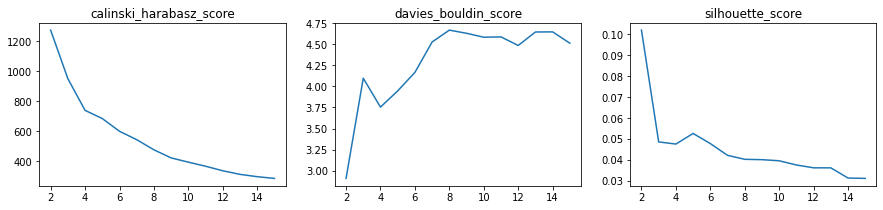

In [37]:
f, ax = plt.subplots(1, 3, figsize=(15, 3))
ax[0].plot(n_cluster_vals, ch)
ax[0].set_title("calinski_harabasz_score")
ax[1].plot(n_cluster_vals, db)
ax[1].set_title("davies_bouldin_score")
ax[2].plot(n_cluster_vals, sh)
ax[2].set_title("silhouette_score");

# PCA for visualization

In [38]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X=corpus_embeddings)
print(pca_result.shape)

(15863, 3)


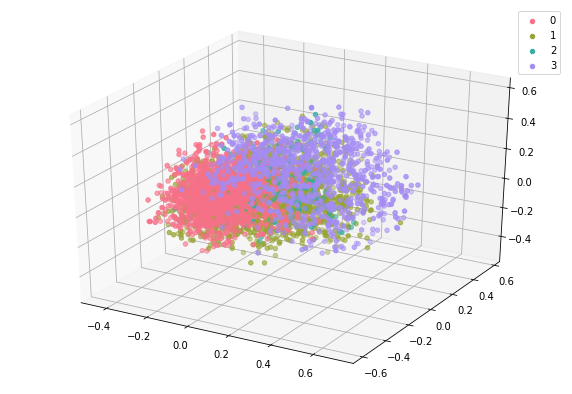

In [39]:
# %matplotlib notebook   # for interactive display

fig = plt.figure(figsize=(10, 7))
cm = plt.get_cmap('gist_rainbow')
clrs = sns.color_palette('husl', n_colors=n_clusters)  # a list of RGB tuples
ax = plt.axes(projection ="3d")
start_idx = 0
for i in range(n_clusters):
    cluster_mask = cluster_assignment == i
    pca_cluster = pca_result[cluster_mask]
    ax.scatter3D(pca_cluster[:, 0], pca_cluster[:, 1], pca_cluster[:, 2], color=clrs[i], label=i)
plt.legend()